## Task 4 : Introduce real-world noise
Quantum computer are not perfect. so,I simulate the same quantum circuit of task 1 using realistic hardware noise model.The goal is to see how many layer ,I can keep while getting good results even when noise and hardware error start to mess things up.For this i used "ibm_brisbane"  at first i used cswap which was able to compute till 5 not more than that.since cswap is a 3 qubit gate so no real IBM bakkend support so I replace cswap with its dedcomposition.

In [1]:
%matplotlib inline

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit import QuantumCircuit, transpile
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import math

# -------------------------
# Your Galton circuit
# -------------------------
def galton(n_layer):
    n_qubit = n_layer + 1
    qc = QuantumCircuit(n_qubit, n_layer)
    for i in range(n_layer):
        qc.h(i)
        qc.cx(i, i+1)
    if n_layer >= 3:
        for i in range(n_layer - 2):
            qc.cswap(i, i+1, i+2)
    for i in range(n_layer):
        qc.measure(i, i)
    return qc 

# -------------------------
# Gaussian check
# -------------------------
def check_gaussian(hamming_bin, total_qubit):
    full = {i: hamming_bin.get(i, 0) for i in range(total_qubit + 1)}
    x = np.array(list(full.keys()))
    y = np.array(list(full.values()))
    log_y = np.log(y + 1e-9)
    coeffs = np.polyfit(x, log_y, 2)
    fit_y = np.polyval(coeffs, x)
    residuals = log_y - fit_y
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((log_y - np.mean(log_y)) ** 2)
    r_squared = 1 - (ss_res / (ss_tot + 1e-12))
    return r_squared

# -------------------------
# Helper: Hamming bins
# -------------------------
def hamming_bins_from_counts(counts):
    H = Counter()
    for b, f in counts.items():
        H[b.count('1')] += f
    return H


# -------------------------
# Main loop with noise model
# -------------------------
def run_with_real_noise(service, backend_name, max_layers=5, shots=4000):
    backend = service.backend(backend_name)
    noise_model = NoiseModel.from_backend(backend)
    coupling_map = backend.configuration().coupling_map
    basis_gates = backend.configuration().basis_gates

    simulator = AerSimulator(noise_model=noise_model)

    results = []
    for layers in range(2, max_layers + 1):
        qc = galton(layers)
        tqc = transpile(qc, simulator, coupling_map=coupling_map, optimization_level=3, num_processes=1)
        result = simulator.run(tqc, shots=shots).result()
        counts = result.get_counts()

        h_bins = hamming_bins_from_counts(counts)
        r2 = check_gaussian(h_bins, total_qubit=layers)

        results.append((layers, r2))
        print(f"Layers={layers} → Gaussian R²={r2:.4f}")

    return results

# -------------------------
# Run the experiment
# -------------------------
if __name__ == "__main__":
    service = QiskitRuntimeService()  # You must be logged in
    backend_name = "ibm_brisbane"     # or "ibm_torino"
    results = run_with_real_noise(service, backend_name)
    print("Final results:", results)

/opt/.qbraid/environments/qgss_000000/pyenv/lib/python3.11/site-packages/qiskit/compiler/transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(


Layers=2 → Gaussian R²=1.0000
Layers=3 → Gaussian R²=1.0000
Layers=4 → Gaussian R²=0.9984
Layers=5 → Gaussian R²=0.9990
Final results: [(2, np.float64(1.0)), (3, np.float64(0.9999726451147355)), (4, np.float64(0.9983987805708314)), (5, np.float64(0.9990393523456385))]


Using backend: ibm_brisbane

Testing layers = 2
  Hamming bins: {0: 1003, 1: 2073, 2: 1020}
  Gaussian R^2 = 1.0000

Testing layers = 3
  Hamming bins: {2: 1532, 1: 1524, 0: 507, 3: 533}
  Gaussian R^2 = 0.9999

Testing layers = 4
  Hamming bins: {2: 1542, 0: 242, 3: 1028, 4: 237, 1: 1047}
  Gaussian R^2 = 0.9986

Testing layers = 5
  Hamming bins: {2: 1340, 1: 592, 3: 1242, 0: 131, 4: 666, 5: 125}
  Gaussian R^2 = 0.9975

Testing layers = 6
  Hamming bins: {2: 929, 4: 1051, 6: 74, 5: 411, 1: 331, 3: 1242, 0: 58}
  Gaussian R^2 = 0.9986

Testing layers = 7
  Hamming bins: {4: 1169, 3: 1067, 2: 662, 5: 683, 6: 221, 7: 48, 1: 213, 0: 33}
  Gaussian R^2 = 0.9981

Testing layers = 8
  Hamming bins: {3: 866, 2: 402, 4: 1143, 6: 461, 5: 936, 1: 123, 0: 16, 7: 129, 8: 20}
  Gaussian R^2 = 0.9986

Testing layers = 9
  Hamming bins: {4: 1033, 3: 611, 6: 709, 5: 1032, 1: 65, 2: 237, 7: 312, 8: 81, 0: 9, 9: 7}
  Gaussian R^2 = 0.9935

Testing layers = 10
  Hamming bins: {2: 162, 5: 974, 7: 464, 3

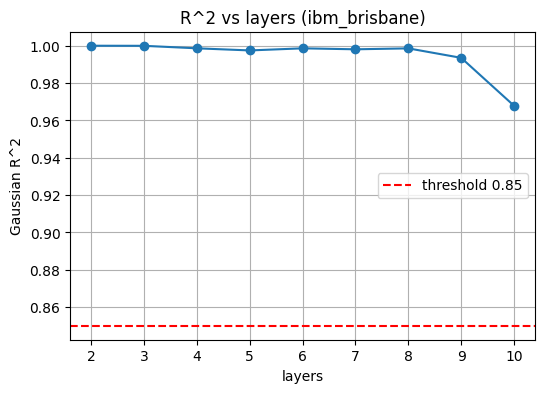

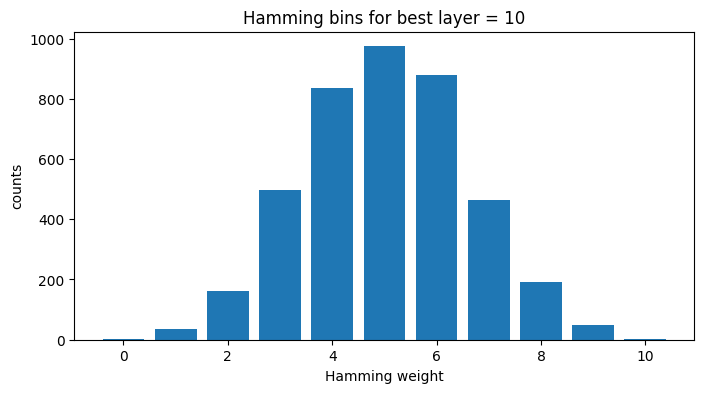


Best layer meeting R^2 threshold: 10
layers=2  R2=1.0000 depth=10 CX=0
layers=3  R2=0.9999 depth=121 CX=0
layers=4  R2=0.9986 depth=278 CX=0
layers=5  R2=0.9975 depth=352 CX=0
layers=6  R2=0.9986 depth=475 CX=0
layers=7  R2=0.9981 depth=586 CX=0
layers=8  R2=0.9986 depth=684 CX=0
layers=9  R2=0.9935 depth=779 CX=0
layers=10  R2=0.9679 depth=996 CX=0


In [3]:
# auto_max_layers_galton.py
# Requirements: qiskit-ibm-runtime, qiskit-aer, numpy, matplotlib

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
#since cswap is a 3 qubit gate so no real IBM bakkend support so I replace cswap with its dedcomposition
def cswap_decompose(qc,control, target2,target1):
    qc.ccx(control, target2,target1)
    qc.ccx(control, target2,target1)
    qc.ccx(control, target2,target1)
# MY  Galton builder

def galton(n_layer):
    n_qubit = n_layer + 1
    qc = QuantumCircuit(n_qubit, n_layer)
    for i in range(n_layer):
        qc.h(i)
        qc.cx(i, i+1)
    if n_layer >= 3:
        for i in range(n_layer - 2):
            cswap_decompose(qc,i, i+1, i+2)
    for i in range(n_layer):
        qc.measure(i, i)
    return qc

# -------------------------
# Helpers: hamming & gaussian R^2
# -------------------------
def hamming_bins_from_counts(counts):
    H = Counter()
    for b, f in counts.items():
        H[b.count('1')] += f
    return H

def gaussian_r2_from_hamming(hamming_bin, total_qubit):
    full = {i: hamming_bin.get(i, 0) for i in range(total_qubit + 1)}
    x = np.array(list(full.keys()))
    y = np.array(list(full.values()), dtype=float)
    # handle all-zero case
    if y.sum() == 0:
        return 0.0
    log_y = np.log(y + 1e-9)
    coeffs = np.polyfit(x, log_y, 2)
    fit_y = np.polyval(coeffs, x)
    residuals = log_y - fit_y
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((log_y - np.mean(log_y)) ** 2)
    r_squared = 1 - (ss_res / (ss_tot + 1e-12))
    return float(r_squared)

# -------------------------
# Sweep routine: find max layers with R2 >= threshold
# -------------------------
def find_max_layers(service, backend_name,
                    start_layers=2, max_layers=18, shots=4096,
                    r2_threshold=0.85, optimization_level=3):
    """Return (best_layer, results_list) where results_list has dicts per tested layer."""
    backend = service.backend(backend_name)
    # backend.name is a property in some Qiskit versions
    backend_str = backend.name if isinstance(backend.name, str) else backend.name()
    print("Using backend:", backend_str)

    # build noise model from the real device
    noise_model = NoiseModel.from_backend(backend)
    coupling_map = backend.configuration().coupling_map
    # Use AerSimulator with noise_model
    simulator = AerSimulator(noise_model=noise_model)

    results = []
    best_layer = None

    for layers in range(start_layers, max_layers + 1):
        print(f"\nTesting layers = {layers}")
        qc = galton(layers)

        # transpile with single-process to avoid multiprocessing errors
        try:
            tqc = transpile(qc, simulator,
                            coupling_map=coupling_map,
                            optimization_level=optimization_level,
                            num_processes=1)
        except TypeError:
            # some Qiskit versions don't support num_processes arg
            tqc = transpile(qc, simulator,
                            coupling_map=coupling_map,
                            optimization_level=optimization_level)
       

        # run noisy sim and get counts
        job = simulator.run(tqc, shots=shots).result()
        counts = job.get_counts()

        # hamming bins and R^2
        h_bins = hamming_bins_from_counts(counts)
        r2 = gaussian_r2_from_hamming(h_bins, total_qubit=layers)
        print(f"  Hamming bins: {dict(h_bins)}")
        print(f"  Gaussian R^2 = {r2:.4f}")

        results.append({
            "layers": layers,
            "counts": counts,
            "hamming": h_bins,
            "r2": r2,
            "depth": tqc.depth(),
            "cx": tqc.count_ops().get('cx', 0)
        })

        if r2 >= r2_threshold:
            best_layer = layers
        else:
            print(f"  R^2 below threshold {r2_threshold}; stopping sweep.")
            break

    # plot R^2 vs layers
    xs = [r["layers"] for r in results]
    ys = [r["r2"] for r in results]
    plt.figure(figsize=(6,4))
    plt.plot(xs, ys, 'o-')
    plt.axhline(r2_threshold, color='red', linestyle='--', label=f"threshold {r2_threshold}")
    plt.xlabel("layers"); plt.ylabel("Gaussian R^2"); plt.title(f"R^2 vs layers ({backend_str})")
    plt.legend(); plt.grid(True); plt.show()

    # final hamming histogram for best layer (if any)
    if best_layer:
        final = next(r for r in results if r['layers'] == best_layer)
        plt.figure(figsize=(8,4))
        keys = sorted(final['hamming'].keys())
        vals = [final['hamming'].get(k,0) for k in keys]
        plt.bar(keys, vals)
        plt.xlabel("Hamming weight"); plt.ylabel("counts")
        plt.title(f"Hamming bins for best layer = {best_layer}")
        plt.show()
    else:
        print("No layer met the R^2 threshold.")

    return best_layer, results

# -------------------------
# Example run (change backend_name if needed)
# -------------------------
if __name__ == "__main__":
    service = QiskitRuntimeService()   # must be logged in in your environment
    backend_name = "ibm_brisbane"      # or "ibm_torino","ibm_brisbane" 
    best_layer, results = find_max_layers(service, backend_name,
                                         start_layers=2, max_layers=10,
                                         shots=4096, r2_threshold=0.85)
    print("\nBest layer meeting R^2 threshold:", best_layer)
    for r in results:
        print(f"layers={r['layers']}  R2={r['r2']:.4f} depth={r['depth']} CX={r['cx']}")

### Conclusion 

In this task, I introduced realistic hardware noise using the ibm_brisbane backend to evaluate how well my quantum walk circuit performs under real-world conditions. Initially, I used the CSWAP gate, but since it is a 3-qubit gate unsupported by real IBM devices, I replaced it with a decomposition using CCX gates.
I tested circuit layers from 2 to 10 and measured the fidelity of the output distribution using Gaussian R² scores. The results showed:
- Layers 2 to 8 maintained near-perfect Gaussian behavior (R² ≥ 0.998), indicating strong resilience to noise.

- Layer 9 showed slight degradation (R² = 0.9935), but still acceptable.

- Layer 10 had the lowest R² (0.9679), yet it still met the threshold of 0.85 set for acceptable fidelity.

Despite increasing circuit depth and realistic noise, the circuit remained statistically robust up to 10 layers, with no CX gates used after transpilation—highlighting the effectiveness of the design and optimization.
